ID 4009
  
type of birth = assisted
expected calving days = +5 day
  
alarm 1
change point:-5.125 days before calving
  
alarm 2
change point:-3.2083333333333335 days before calving
  
alarm 3
change point:-3.125 days before calving
  
alarm 4
change point:-2.0416666666666665 days before calving
  
alarm 5
change point:-0.75 days before calving
  
average alarm to calving day difference = -2.85 days


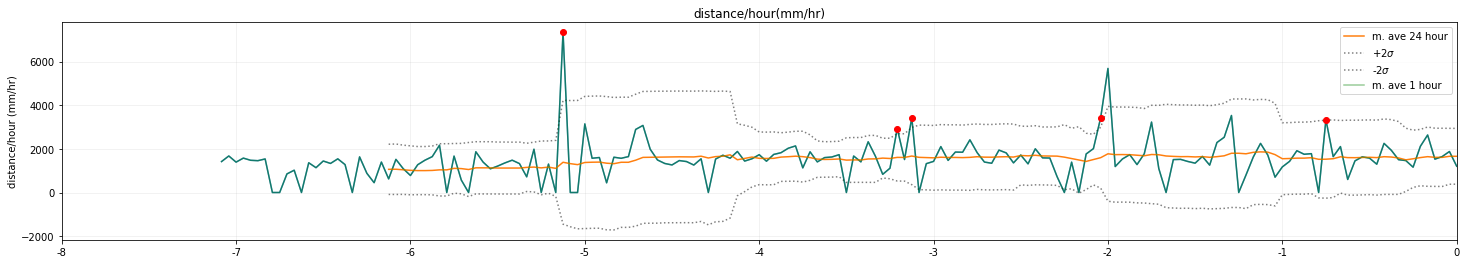

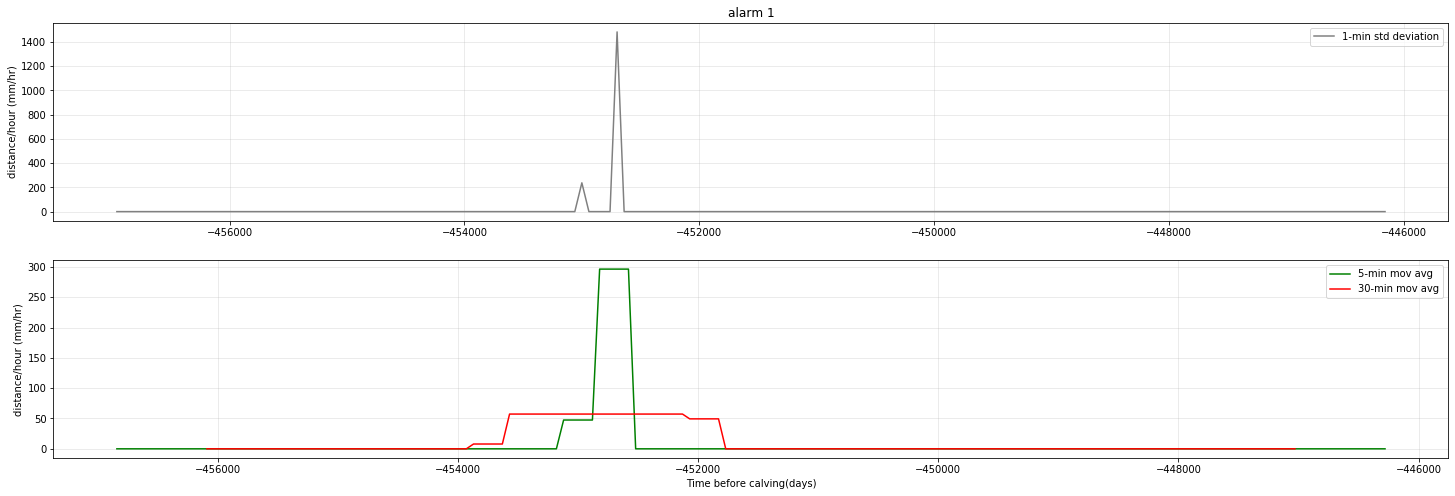

In [118]:
import glob 
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from pandas.tseries.offsets import Hour, Minute
import matplotlib.dates as dates
from numpy import nan as NA
from scipy import stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


filenames = sorted(glob.glob('./Documents/nakayama_calc_all/4009.csv'))
for file in filenames:
    
    df1=pd.read_csv(file,sep=',',converters={'datetime': pd.to_datetime})

    
    s = file.rfind("/")
    e = file.rfind("csv")
    cowID = file[s+1:e-1]
    delta = df1['delta'].iloc[0]
    birth = df1['type'].iloc[0]
    
    
    
    print("ID " + cowID)
    print("  ")
    print("type of birth =", birth)
    print("expected calving days =", '%+d' % delta, "day")
    
    
    # Extract necessary columns and truncate to the second. Then devide into move and stop

    df2=df1.loc[:,['datetime','movement','distance','timedelta']]
    date=df2.loc[:,'datetime']
    dhm=[]
    for d in date:
        hm=datetime(d.year, d.month, d.day, d.hour)
        dhm.append(hm)
    df2['dhm']=dhm
    df_move=df2.query('movement=="move"')
    df_stop=df2.query('movement=="stop"')
    df_move.head()

    # After grouping every minute, the number of rows in the group was counted to determine the frequency. I used frequency as the number of moves.
    # calculated "distance/movingtime" instead of stride.

    #for move
    groupm=df_move.groupby('dhm')
    move=groupm.std()
    temp=groupm.count()
    move=move.reset_index(drop=False)
    temp=temp.reset_index(drop=False)
    move=pd.merge(move, temp, on='dhm', how='outer')
    move=move.iloc[:,:4]
    move.columns=['datetime','distance','movingtime','frequency']
    move['speed']=round(move['distance']/move['movingtime'],2)
    move['movingMin']=round(move['movingtime']/60,2)
    #move.head()


    # Make a timeindex every minute from the beginning to the end.(newdate)
    # df2 contains stop rows.

    start=move.iloc[0,0]
    start=str(start)
    end=df2.iloc[-1,0]
    end=str(end)
    newdate=pd.date_range(start,end, freq='H')

    temp=pd.DataFrame({'datetime':newdate})
    #temp.head()


    # The timeindex(temp) and move table were merged to create a table with a row every minute.

    df3=pd.merge(temp, move, on=['datetime'], how='outer')
    df3.head()

    df3=df3.fillna(0)
    df3.head()


    # Since one line is 1hour, 60-movingMin indicates stoppingMin.

    df3['stoppingMin']=60-df3['movingMin']
    df3.head()
    df3.tail()

    a = 1 
    b = 24
    c = 48
    df4=df3.set_index('datetime', drop=True)
    df5=df4.rolling(b).mean()
    df6=df4.rolling(c).mean()
    
    df4=df4.reset_index(drop=False)
    caltime=df4.iloc[-1,0]
    before=[]
    for d in df4.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df4['beforeCalv']=before


    df5=df5.reset_index(drop=False)
    caltime=df5.iloc[-1,0]
    before=[]
    for d in df5.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df5['beforeCalv']=before
    

    df6=df6.reset_index(drop=False)
    caltime=df6.iloc[-1,0]
    before=[]
    for d in df6.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df6['beforeCalv']=before

    
    merged = df5.merge(df6, on='datetime')
    merged['comparison'] = merged['distance_x']/merged['distance_y']
    
    beginDay= -(df5.iloc[-1,0]-df5.iloc[0,0]).days -1
    during= beginDay*24*60*60
    mpl.rcParams['figure.figsize']=[25,8]
    #sns.set_context('poster')
    
    lowess = sm.nonparametric.lowess(merged['comparison'], merged['beforeCalv_x'], frac=0.1) #LOWESS 
    
    datelist = []
    secondlist = []
    
    def mean(datelist): 
        return sum(datelist) / len(datelist) 
    
    def calc_bb(name, df, window=1):
    # Bollinger Band using 2sigma
        plt.figure(figsize=(25,4))
        plt.title("distance/hour(mm/hr)")
        plt.plot(df['beforeCalv'], df[name])
        
        
        n_window = 1
        m_ave = df[name].rolling(window= n_window).mean() 
        m = df[name].rolling(window=window).mean()
        sigma = df[name].rolling(window=window).std()
        
        n_sigma = 2

        df["m"] = m
        df["m+2s"] = m+n_sigma*sigma
        df["m-2s"] = m-n_sigma*sigma

        #df["up"] = df[name] - df["m+2s"]
        #df["down"] = df["m-2s"] - df[name]

        df["up"] = m_ave - df["m+2s"]
        df["down"] = df["m-2s"] - m_ave

        plt.plot(df['beforeCalv'],m, label="m. ave "+str(window)+" hour")
        plt.plot(df['beforeCalv'],m+n_sigma*sigma,label="+"+ str(n_sigma) +"$\sigma$",color="k",alpha=0.5,linestyle="dotted")
        plt.plot(df['beforeCalv'],m-n_sigma*sigma,label="-"+ str(n_sigma) +"$\sigma$",color="k", alpha=0.5,linestyle="dotted")
        plt.plot(df['beforeCalv'],m_ave,label="m. ave "+str(n_window)+" hour",color="green",alpha=0.4)
        #plt.plot(df.index, df[name].rolling(window=3*window).mean(),label="{}min".format(window*30))
        
        for i in range(1,len(df)):
            if df.iloc[i-1]["up"] < 0 and df.iloc[i]["up"] >= 0:
                changepoint = df.iloc[i]["beforeCalv"]
                datelist.append(changepoint)
                secondlist.append(changepoint*-1)
                plt.plot(df['beforeCalv'][i],df.iloc[i][name],"o",color="red",markersize=6)
                print("  ")
                print("alarm", len(datelist))
                print("change point:{}".format((df.iloc[i]["beforeCalv"]/24/60/60))+' days before calving')
                

        average = mean(datelist)/24/60/60
        print("  ")
        print("average alarm to calving day difference =", round(average, 2), "days")
        #print("window size:", n_window, "hour", ",", window, "hour")
        

            #if df.iloc[i-1]["down"] < 0 and df.iloc[i]["down"] >= 0:
                #print("change point decrease time:{}".format(np.round(df.iloc[i]["beforeCalv"]/86400), decimals=5)+' days before calving')
                #plt.plot(df['beforeCalv'][i],df.iloc[i][name],"o",color="blue",markersize=6)

        plt.xlim([during,1])
        plt.xticks(np.arange(during,1,86400),(np.arange(beginDay,1)))
        plt.grid(True, alpha=0.2)
        plt.legend(loc='best')
        #plt.xlabel('Time before calving (days)')
        plt.ylabel('distance/hour (mm/hr)')
        plt.show()

    df = df4
    calc_bb("distance", df, window=24)
    '''
    f, (ax1, ax2) = plt.subplots(2,1, sharex=False)
    
    ax1.plot(df6['beforeCalv'], df4['distance'],label = str(a) + '-h std deviation' , color='grey')
    ax2.plot(df5['beforeCalv'], df5['distance'],label = str(b) + '-h mov avg' , color='green')
    ax2.plot(df6['beforeCalv'], df6['distance'], color='r', label=str(c) + '-h mov avg')
    #ax3.plot(merged['beforeCalv_x'], merged['comparison'], label='comparison')
    #ax3.plot(lowess[:, 0], lowess[:, 1], label='smoothing')
    
    #plt.legend(loc='best')
    #ax1.set_title('distance/hour (mm/hr)')
    
    ax1.grid(True, alpha = 0.3)
    ax2.grid(True, alpha = 0.3)
    #ax3.grid(True, alpha = 0.3)
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    #ax3.legend(loc='best')

    ax1.set_xlim([during,1])
    ax1.set_xticks(np.arange(during,1,86400))
    ax1.set_xticklabels(np.arange(beginDay,1)) 
    #ax1.set_xlabel('Time before calving(days)')
    ax1.set_ylabel('distance/hour (mm/hr)')
    
    ax2.set_xlim([during,1])
    ax2.set_xticks(np.arange(during,1,86400))
    ax2.set_xticklabels(np.arange(beginDay,1)) 
    ax2.set_xlabel('Time before calving(days)')
    ax2.set_ylabel('distance/hour (mm/hr)')
    
    #ax3.set_xlim([during,1])
    #ax3.set_xticks(np.arange(during,1,86400))
    #ax3.set_xticklabels(np.arange(beginDay,1)) 
    #plt.savefig(file[:-4]+ '_plot.png')
    '''
    
    result = df4[pd.DataFrame(df4.beforeCalv.tolist()).isin(datelist).any(1)]
    result['datetimemin'] = result['datetime'] - timedelta(hours=3)  
    result['datetimemax'] = result['datetime'] + timedelta(hours=0) 
    result = result.loc[:,['datetimemin','datetimemax']]
    
    
    df10=df1.loc[:,['datetime','movement','distance','timedelta']]
    date=df10.loc[:,'datetime']
    dhm=[]
    for d in date:
        hm=datetime(d.year, d.month, d.day, d.hour, d.minute)
        dhm.append(hm)
    df10['dhm']=dhm
    df_move=df10.query('movement=="move"')
    df_stop=df10.query('movement=="stop"')
    df_move.head()
    
    groupm=df_move.groupby('dhm')
    move=groupm.std()
    temp=groupm.count()
    move=move.reset_index(drop=False)
    temp=temp.reset_index(drop=False)
    move=pd.merge(move, temp, on='dhm', how='outer')
    move=move.iloc[:,:4]
    move.columns=['datetime','distance','movingtime','frequency']
    #move['speed']=round(move['distance']/move['movingtime'],2)
    move['movingMin']=round(move['movingtime']/60,2)
    #move.head()
    start=move.iloc[0,0]
    start=str(start)
    end=df10.iloc[-1,0]
    end=str(end)
    newdate=pd.date_range(start,end, freq='T')

    temp=pd.DataFrame({'datetime':newdate})
    
    df11=pd.merge(temp, move, on=['datetime'], how='outer')
    df11.head()

    df11=df11.fillna(0)
    df11.head()

    df11['stoppingMin']=1-df3['movingMin'] #1minutes - moving time
    df12=df11.set_index('datetime', drop=True)
    
      
    df12=df12.reset_index(drop=False)
    caltime=df12.iloc[-1,0]
    before=[]
    for d in df12.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df12['beforeCalv']=before
    df12=df12.set_index('datetime', drop=True)
    
    x = str(result.iloc[0,0])
    y = str(result.iloc[0,1])

    df12 = df12.loc[x:y]

    a = 1
    b = 5
    c = 30

    df13=df12.rolling(b).mean()
    df14=df12.rolling(c).mean()

    beginDay= -(df5.iloc[-1,0]-df5.iloc[0,0])
    during= beginDay

    f, (ax1, ax2) = plt.subplots(2,1, sharex=False)

    ax1.plot(df12['beforeCalv'], df12['distance'],label = str(a) + '-min std deviation' , color='grey')
    ax2.plot(df13['beforeCalv'], df13['distance'],label = str(b) + '-min mov avg' , color='green')
    ax2.plot(df14['beforeCalv'], df14['distance'], color='r', label=str(c) + '-min mov avg')
    #ax3.plot(merged['beforeCalv_x'], merged['comparison'], label='comparison')
    #ax3.plot(lowess[:, 0], lowess[:, 1], label='smoothing')

    #plt.legend(loc='best')
    #ax1.set_title('distance/hour (mm/hr)')

    ax1.grid(True, alpha = 0.3)
    ax2.grid(True, alpha = 0.3)
    #ax3.grid(True, alpha = 0.3)

    ax1.legend(loc='best')
    ax2.legend(loc='best')
    #ax3.legend(loc='best')

    #ax1.set_xlim([during,1])
    #ax1.set_xticks(np.arange(during,1,86400))
    #ax1.set_xticklabels(np.arange(beginDay,1)) 
    #ax1.set_xlabel('Time before calving(days)')
    ax1.set_ylabel('distance/hour (mm/hr)')
    ax1.set_title('alarm 1')

    #ax2.set_xlim([during,1])
    #ax2.set_xticks(np.arange(during,1,86400))
    #ax2.set_xticklabels(np.arange(beginDay,1)) 
    ax2.set_xlabel('Time before calving(days)')
    ax2.set_ylabel('distance/hour (mm/hr)')
    
    



ID 3986
  
type of birth = natural
expected calving days = -4 day
  
alarm 1
change point:-4.666666666666667 days before calving
  
alarm 2
change point:-4.25 days before calving
  
alarm 3
change point:-2.0 days before calving
  
average alarm to calving day difference = -3.64 days


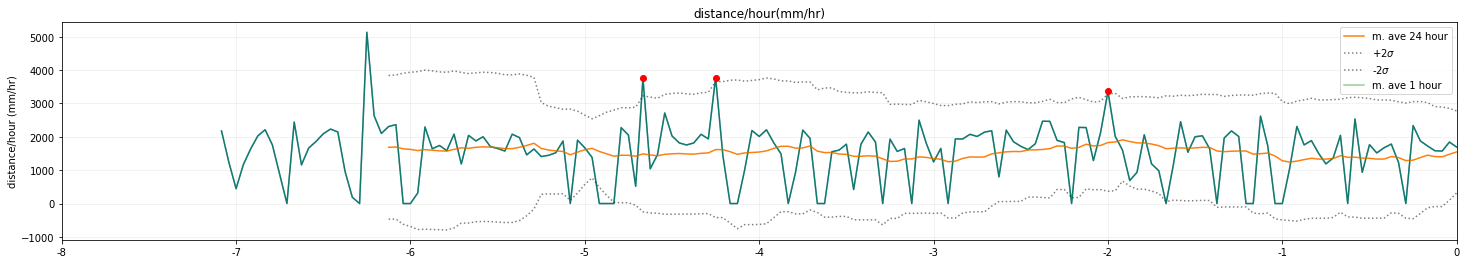

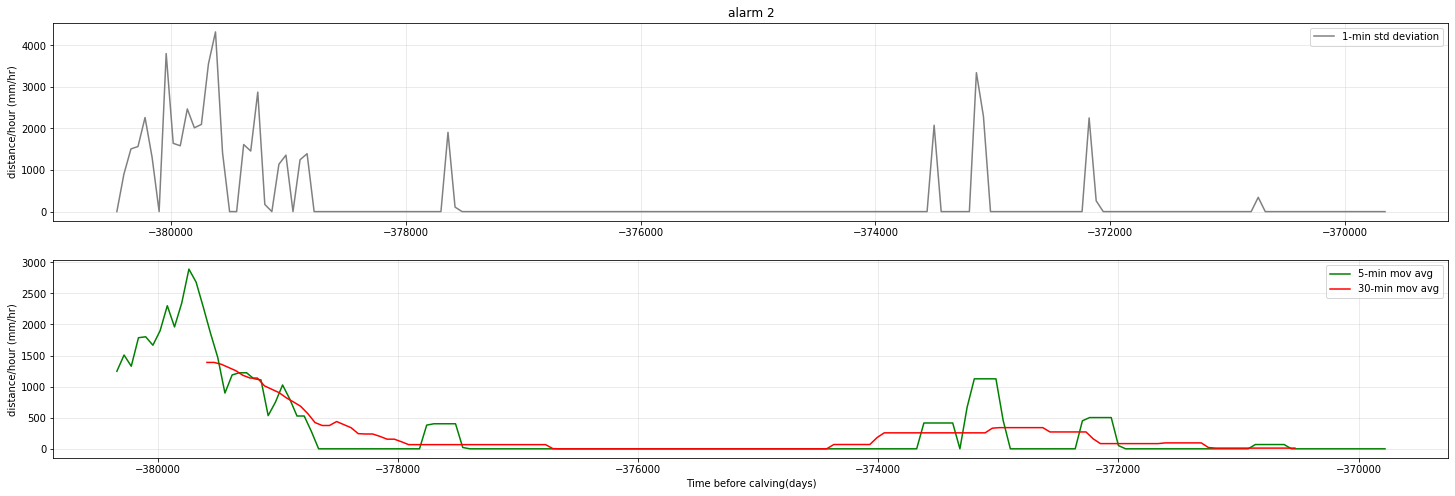

In [96]:
import glob 
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from pandas.tseries.offsets import Hour, Minute
import matplotlib.dates as dates
from numpy import nan as NA
from scipy import stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


filenames = sorted(glob.glob('./Documents/nakayama_calc_all/3986.csv'))
for file in filenames:
    
    df1=pd.read_csv(file,sep=',',converters={'datetime': pd.to_datetime})

    
    s = file.rfind("/")
    e = file.rfind("csv")
    cowID = file[s+1:e-1]
    delta = df1['delta'].iloc[0]
    birth = df1['type'].iloc[0]
    
    
    
    print("ID " + cowID)
    print("  ")
    print("type of birth =", birth)
    print("expected calving days =", '%+d' % delta, "day")
    
    
    # Extract necessary columns and truncate to the second. Then devide into move and stop

    df2=df1.loc[:,['datetime','movement','distance','timedelta']]
    date=df2.loc[:,'datetime']
    dhm=[]
    for d in date:
        hm=datetime(d.year, d.month, d.day, d.hour)
        dhm.append(hm)
    df2['dhm']=dhm
    df_move=df2.query('movement=="move"')
    df_stop=df2.query('movement=="stop"')
    df_move.head()

    # After grouping every minute, the number of rows in the group was counted to determine the frequency. I used frequency as the number of moves.
    # calculated "distance/movingtime" instead of stride.

    #for move
    groupm=df_move.groupby('dhm')
    move=groupm.std()
    temp=groupm.count()
    move=move.reset_index(drop=False)
    temp=temp.reset_index(drop=False)
    move=pd.merge(move, temp, on='dhm', how='outer')
    move=move.iloc[:,:4]
    move.columns=['datetime','distance','movingtime','frequency']
    move['speed']=round(move['distance']/move['movingtime'],2)
    move['movingMin']=round(move['movingtime']/60,2)
    #move.head()


    # Make a timeindex every minute from the beginning to the end.(newdate)
    # df2 contains stop rows.

    start=move.iloc[0,0]
    start=str(start)
    end=df2.iloc[-1,0]
    end=str(end)
    newdate=pd.date_range(start,end, freq='H')

    temp=pd.DataFrame({'datetime':newdate})
    #temp.head()


    # The timeindex(temp) and move table were merged to create a table with a row every minute.

    df3=pd.merge(temp, move, on=['datetime'], how='outer')
    df3.head()

    df3=df3.fillna(0)
    df3.head()


    # Since one line is 1hour, 60-movingMin indicates stoppingMin.

    df3['stoppingMin']=60-df3['movingMin']
    df3.head()
    df3.tail()

    a = 1 
    b = 24
    c = 48
    df4=df3.set_index('datetime', drop=True)
    df5=df4.rolling(b).mean()
    df6=df4.rolling(c).mean()
    
    df4=df4.reset_index(drop=False)
    caltime=df4.iloc[-1,0]
    before=[]
    for d in df4.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df4['beforeCalv']=before


    df5=df5.reset_index(drop=False)
    caltime=df5.iloc[-1,0]
    before=[]
    for d in df5.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df5['beforeCalv']=before
    

    df6=df6.reset_index(drop=False)
    caltime=df6.iloc[-1,0]
    before=[]
    for d in df6.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df6['beforeCalv']=before

    
    merged = df5.merge(df6, on='datetime')
    merged['comparison'] = merged['distance_x']/merged['distance_y']
    
    beginDay= -(df5.iloc[-1,0]-df5.iloc[0,0]).days -1
    during= beginDay*24*60*60
    mpl.rcParams['figure.figsize']=[25,8]
    #sns.set_context('poster')
    
    lowess = sm.nonparametric.lowess(merged['comparison'], merged['beforeCalv_x'], frac=0.1) #LOWESS 
    
    datelist = []
    secondlist = []
    
    def mean(datelist): 
        return sum(datelist) / len(datelist) 
    
    def calc_bb(name, df, window=1):
    # Bollinger Band using 2sigma
        plt.figure(figsize=(25,4))
        plt.title("distance/hour(mm/hr)")
        plt.plot(df['beforeCalv'], df[name])
        
        
        n_window = 1
        m_ave = df[name].rolling(window= n_window).mean() 
        m = df[name].rolling(window=window).mean()
        sigma = df[name].rolling(window=window).std()
        
        n_sigma = 2

        df["m"] = m
        df["m+2s"] = m+n_sigma*sigma
        df["m-2s"] = m-n_sigma*sigma

        #df["up"] = df[name] - df["m+2s"]
        #df["down"] = df["m-2s"] - df[name]

        df["up"] = m_ave - df["m+2s"]
        df["down"] = df["m-2s"] - m_ave

        plt.plot(df['beforeCalv'],m, label="m. ave "+str(window)+" hour")
        plt.plot(df['beforeCalv'],m+n_sigma*sigma,label="+"+ str(n_sigma) +"$\sigma$",color="k",alpha=0.5,linestyle="dotted")
        plt.plot(df['beforeCalv'],m-n_sigma*sigma,label="-"+ str(n_sigma) +"$\sigma$",color="k", alpha=0.5,linestyle="dotted")
        plt.plot(df['beforeCalv'],m_ave,label="m. ave "+str(n_window)+" hour",color="green",alpha=0.4)
        #plt.plot(df.index, df[name].rolling(window=3*window).mean(),label="{}min".format(window*30))
        
        for i in range(1,len(df)):
            if df.iloc[i-1]["up"] < 0 and df.iloc[i]["up"] >= 0:
                changepoint = df.iloc[i]["beforeCalv"]
                datelist.append(changepoint)
                secondlist.append(changepoint*-1)
                plt.plot(df['beforeCalv'][i],df.iloc[i][name],"o",color="red",markersize=6)
                print("  ")
                print("alarm", len(datelist))
                print("change point:{}".format((df.iloc[i]["beforeCalv"]/24/60/60))+' days before calving')
                

        average = mean(datelist)/24/60/60
        print("  ")
        print("average alarm to calving day difference =", round(average, 2), "days")
        #print("window size:", n_window, "hour", ",", window, "hour")
        

            #if df.iloc[i-1]["down"] < 0 and df.iloc[i]["down"] >= 0:
                #print("change point decrease time:{}".format(np.round(df.iloc[i]["beforeCalv"]/86400), decimals=5)+' days before calving')
                #plt.plot(df['beforeCalv'][i],df.iloc[i][name],"o",color="blue",markersize=6)

        plt.xlim([during,1])
        plt.xticks(np.arange(during,1,86400),(np.arange(beginDay,1)))
        plt.grid(True, alpha=0.2)
        plt.legend(loc='best')
        #plt.xlabel('Time before calving (days)')
        plt.ylabel('distance/hour (mm/hr)')
        plt.show()

    df = df4
    calc_bb("distance", df, window=24)
    '''
    f, (ax1, ax2) = plt.subplots(2,1, sharex=False)
    
    ax1.plot(df6['beforeCalv'], df4['distance'],label = str(a) + '-h std deviation' , color='grey')
    ax2.plot(df5['beforeCalv'], df5['distance'],label = str(b) + '-h mov avg' , color='green')
    ax2.plot(df6['beforeCalv'], df6['distance'], color='r', label=str(c) + '-h mov avg')
    #ax3.plot(merged['beforeCalv_x'], merged['comparison'], label='comparison')
    #ax3.plot(lowess[:, 0], lowess[:, 1], label='smoothing')
    
    #plt.legend(loc='best')
    #ax1.set_title('distance/hour (mm/hr)')
    
    ax1.grid(True, alpha = 0.3)
    ax2.grid(True, alpha = 0.3)
    #ax3.grid(True, alpha = 0.3)
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    #ax3.legend(loc='best')

    ax1.set_xlim([during,1])
    ax1.set_xticks(np.arange(during,1,86400))
    ax1.set_xticklabels(np.arange(beginDay,1)) 
    #ax1.set_xlabel('Time before calving(days)')
    ax1.set_ylabel('distance/hour (mm/hr)')
    
    ax2.set_xlim([during,1])
    ax2.set_xticks(np.arange(during,1,86400))
    ax2.set_xticklabels(np.arange(beginDay,1)) 
    ax2.set_xlabel('Time before calving(days)')
    ax2.set_ylabel('distance/hour (mm/hr)')
    
    #ax3.set_xlim([during,1])
    #ax3.set_xticks(np.arange(during,1,86400))
    #ax3.set_xticklabels(np.arange(beginDay,1)) 
    #plt.savefig(file[:-4]+ '_plot.png')
    '''
    
    result = df4[pd.DataFrame(df4.beforeCalv.tolist()).isin(datelist).any(1)]
    result['datetimemin'] = result['datetime'] - timedelta(hours=3)  
    result['datetimemax'] = result['datetime'] + timedelta(hours=0) 
    result = result.loc[:,['datetimemin','datetimemax']]
    
    
    df10=df1.loc[:,['datetime','movement','distance','timedelta']]
    date=df10.loc[:,'datetime']
    dhm=[]
    for d in date:
        hm=datetime(d.year, d.month, d.day, d.hour, d.minute)
        dhm.append(hm)
    df10['dhm']=dhm
    df_move=df10.query('movement=="move"')
    df_stop=df10.query('movement=="stop"')
    df_move.head()
    
    groupm=df_move.groupby('dhm')
    move=groupm.std()
    temp=groupm.count()
    move=move.reset_index(drop=False)
    temp=temp.reset_index(drop=False)
    move=pd.merge(move, temp, on='dhm', how='outer')
    move=move.iloc[:,:4]
    move.columns=['datetime','distance','movingtime','frequency']
    #move['speed']=round(move['distance']/move['movingtime'],2)
    move['movingMin']=round(move['movingtime']/60,2)
    #move.head()
    start=move.iloc[0,0]
    start=str(start)
    end=df10.iloc[-1,0]
    end=str(end)
    newdate=pd.date_range(start,end, freq='T')

    temp=pd.DataFrame({'datetime':newdate})
    
    df11=pd.merge(temp, move, on=['datetime'], how='outer')
    df11.head()

    df11=df11.fillna(0)
    df11.head()

    df11['stoppingMin']=1-df3['movingMin'] #1minutes - moving time
    df12=df11.set_index('datetime', drop=True)
    
      
    df12=df12.reset_index(drop=False)
    caltime=df12.iloc[-1,0]
    before=[]
    for d in df12.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df12['beforeCalv']=before
    df12=df12.set_index('datetime', drop=True)
    
    x = str(result.iloc[1,0])
    y = str(result.iloc[1,1])

    df12 = df12.loc[x:y]

    a = 1
    b = 5
    c = 30

    df13=df12.rolling(b).mean()
    df14=df12.rolling(c).mean()

    beginDay= -(df5.iloc[-1,0]-df5.iloc[0,0])
    during= beginDay

    f, (ax1, ax2) = plt.subplots(2,1, sharex=False)

    ax1.plot(df12['beforeCalv'], df12['distance'],label = str(a) + '-min std deviation' , color='grey')
    ax2.plot(df13['beforeCalv'], df13['distance'],label = str(b) + '-min mov avg' , color='green')
    ax2.plot(df14['beforeCalv'], df14['distance'], color='r', label=str(c) + '-min mov avg')
    #ax3.plot(merged['beforeCalv_x'], merged['comparison'], label='comparison')
    #ax3.plot(lowess[:, 0], lowess[:, 1], label='smoothing')

    #plt.legend(loc='best')
    #ax1.set_title('distance/hour (mm/hr)')

    ax1.grid(True, alpha = 0.3)
    ax2.grid(True, alpha = 0.3)
    #ax3.grid(True, alpha = 0.3)

    ax1.legend(loc='best')
    ax2.legend(loc='best')
    #ax3.legend(loc='best')

    #ax1.set_xlim([during,1])
    #ax1.set_xticks(np.arange(during,1,86400))
    #ax1.set_xticklabels(np.arange(beginDay,1)) 
    #ax1.set_xlabel('Time before calving(days)')
    ax1.set_ylabel('distance/hour (mm/hr)')
    ax1.set_title('alarm 2')

    #ax2.set_xlim([during,1])
    #ax2.set_xticks(np.arange(during,1,86400))
    #ax2.set_xticklabels(np.arange(beginDay,1)) 
    ax2.set_xlabel('Time before calving(days)')
    ax2.set_ylabel('distance/hour (mm/hr)')
    
    



ID 3986
  
type of birth = natural
expected calving days = -4 day
  
alarm 1
change point:-403200 days before calving
  
alarm 2
change point:-367200 days before calving
  
alarm 3
change point:-172800 days before calving
  
average alarm to calving day difference = -3.64 days


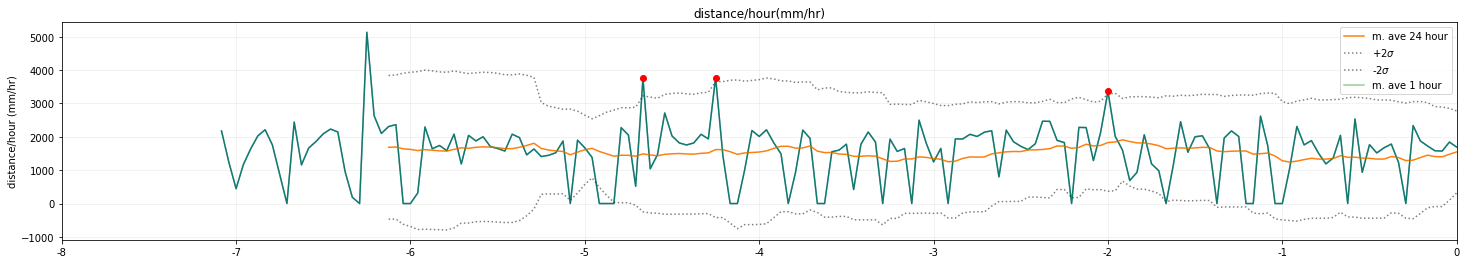

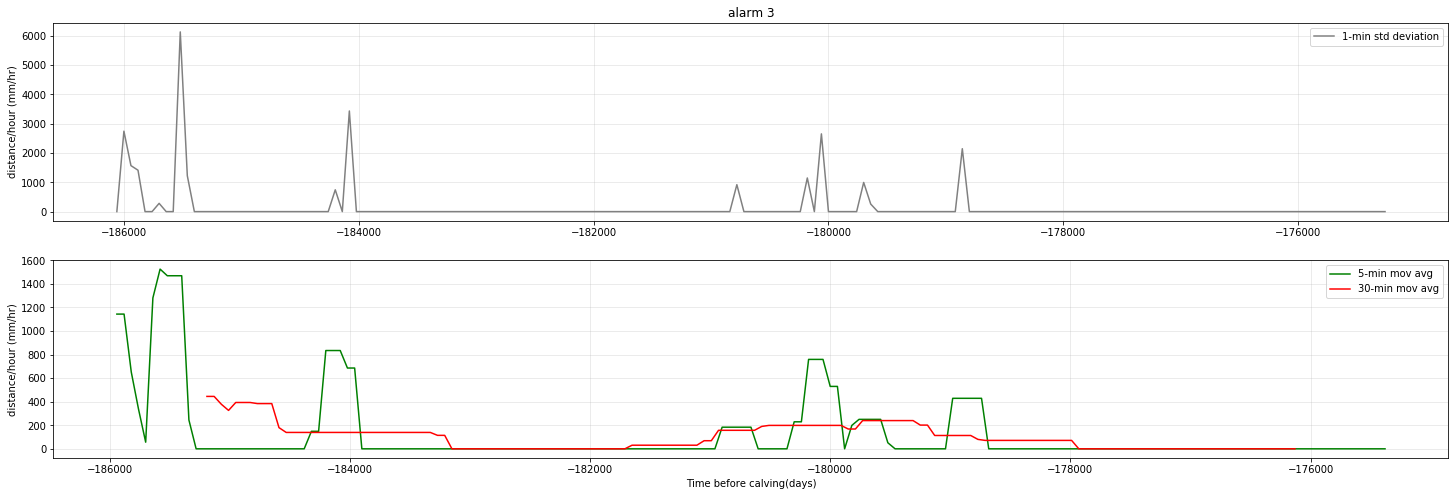

In [100]:
import glob 
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from pandas.tseries.offsets import Hour, Minute
import matplotlib.dates as dates
from numpy import nan as NA
from scipy import stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


filenames = sorted(glob.glob('./Documents/nakayama_calc_all/3986.csv'))
for file in filenames:
    
    df1=pd.read_csv(file,sep=',',converters={'datetime': pd.to_datetime})

    
    s = file.rfind("/")
    e = file.rfind("csv")
    cowID = file[s+1:e-1]
    delta = df1['delta'].iloc[0]
    birth = df1['type'].iloc[0]
    
    
    
    print("ID " + cowID)
    print("  ")
    print("type of birth =", birth)
    print("expected calving days =", '%+d' % delta, "day")
    
    
    # Extract necessary columns and truncate to the second. Then devide into move and stop

    df2=df1.loc[:,['datetime','movement','distance','timedelta']]
    date=df2.loc[:,'datetime']
    dhm=[]
    for d in date:
        hm=datetime(d.year, d.month, d.day, d.hour)
        dhm.append(hm)
    df2['dhm']=dhm
    df_move=df2.query('movement=="move"')
    df_stop=df2.query('movement=="stop"')
    df_move.head()

    # After grouping every minute, the number of rows in the group was counted to determine the frequency. I used frequency as the number of moves.
    # calculated "distance/movingtime" instead of stride.

    #for move
    groupm=df_move.groupby('dhm')
    move=groupm.std()
    temp=groupm.count()
    move=move.reset_index(drop=False)
    temp=temp.reset_index(drop=False)
    move=pd.merge(move, temp, on='dhm', how='outer')
    move=move.iloc[:,:4]
    move.columns=['datetime','distance','movingtime','frequency']
    move['speed']=round(move['distance']/move['movingtime'],2)
    move['movingMin']=round(move['movingtime']/60,2)
    #move.head()


    # Make a timeindex every minute from the beginning to the end.(newdate)
    # df2 contains stop rows.

    start=move.iloc[0,0]
    start=str(start)
    end=df2.iloc[-1,0]
    end=str(end)
    newdate=pd.date_range(start,end, freq='H')

    temp=pd.DataFrame({'datetime':newdate})
    #temp.head()


    # The timeindex(temp) and move table were merged to create a table with a row every minute.

    df3=pd.merge(temp, move, on=['datetime'], how='outer')
    df3.head()

    df3=df3.fillna(0)
    df3.head()


    # Since one line is 1hour, 60-movingMin indicates stoppingMin.

    df3['stoppingMin']=60-df3['movingMin']
    df3.head()
    df3.tail()

    a = 1 
    b = 24
    c = 48
    df4=df3.set_index('datetime', drop=True)
    df5=df4.rolling(b).mean()
    df6=df4.rolling(c).mean()
    
    df4=df4.reset_index(drop=False)
    caltime=df4.iloc[-1,0]
    before=[]
    for d in df4.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df4['beforeCalv']=before


    df5=df5.reset_index(drop=False)
    caltime=df5.iloc[-1,0]
    before=[]
    for d in df5.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df5['beforeCalv']=before
    

    df6=df6.reset_index(drop=False)
    caltime=df6.iloc[-1,0]
    before=[]
    for d in df6.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df6['beforeCalv']=before

    
    merged = df5.merge(df6, on='datetime')
    merged['comparison'] = merged['distance_x']/merged['distance_y']
    
    beginDay= -(df5.iloc[-1,0]-df5.iloc[0,0]).days -1
    during= beginDay*24*60*60
    mpl.rcParams['figure.figsize']=[25,8]
    #sns.set_context('poster')
    
    lowess = sm.nonparametric.lowess(merged['comparison'], merged['beforeCalv_x'], frac=0.1) #LOWESS 
    
    datelist = []
    secondlist = []
    
    def mean(datelist): 
        return sum(datelist) / len(datelist) 
    
    def calc_bb(name, df, window=1):
    # Bollinger Band using 2sigma
        plt.figure(figsize=(25,4))
        plt.title("distance/hour(mm/hr)")
        plt.plot(df['beforeCalv'], df[name])
        
        
        n_window = 1
        m_ave = df[name].rolling(window= n_window).mean() 
        m = df[name].rolling(window=window).mean()
        sigma = df[name].rolling(window=window).std()
        
        n_sigma = 2

        df["m"] = m
        df["m+2s"] = m+n_sigma*sigma
        df["m-2s"] = m-n_sigma*sigma

        #df["up"] = df[name] - df["m+2s"]
        #df["down"] = df["m-2s"] - df[name]

        df["up"] = m_ave - df["m+2s"]
        df["down"] = df["m-2s"] - m_ave

        plt.plot(df['beforeCalv'],m, label="m. ave "+str(window)+" hour")
        plt.plot(df['beforeCalv'],m+n_sigma*sigma,label="+"+ str(n_sigma) +"$\sigma$",color="k",alpha=0.5,linestyle="dotted")
        plt.plot(df['beforeCalv'],m-n_sigma*sigma,label="-"+ str(n_sigma) +"$\sigma$",color="k", alpha=0.5,linestyle="dotted")
        plt.plot(df['beforeCalv'],m_ave,label="m. ave "+str(n_window)+" hour",color="green",alpha=0.4)
        #plt.plot(df.index, df[name].rolling(window=3*window).mean(),label="{}min".format(window*30))
        
        for i in range(1,len(df)):
            if df.iloc[i-1]["up"] < 0 and df.iloc[i]["up"] >= 0:
                changepoint = df.iloc[i]["beforeCalv"]
                datelist.append(changepoint)
                secondlist.append(changepoint*-1)
                plt.plot(df['beforeCalv'][i],df.iloc[i][name],"o",color="red",markersize=6)
                print("  ")
                print("alarm", len(datelist))
                print("change point:{}".format((df.iloc[i]["beforeCalv"]))+' days before calving')
                

        average = mean(datelist)/24/60/60
        print("  ")
        print("average alarm to calving day difference =", round(average, 2), "days")
        #print("window size:", n_window, "hour", ",", window, "hour")
        

            #if df.iloc[i-1]["down"] < 0 and df.iloc[i]["down"] >= 0:
                #print("change point decrease time:{}".format(np.round(df.iloc[i]["beforeCalv"]/86400), decimals=5)+' days before calving')
                #plt.plot(df['beforeCalv'][i],df.iloc[i][name],"o",color="blue",markersize=6)

        plt.xlim([during,1])
        plt.xticks(np.arange(during,1,86400),(np.arange(beginDay,1)))
        plt.grid(True, alpha=0.2)
        plt.legend(loc='best')
        #plt.xlabel('Time before calving (days)')
        plt.ylabel('distance/hour (mm/hr)')
        plt.show()

    df = df4
    calc_bb("distance", df, window=24)
    '''
    f, (ax1, ax2) = plt.subplots(2,1, sharex=False)
    
    ax1.plot(df6['beforeCalv'], df4['distance'],label = str(a) + '-h std deviation' , color='grey')
    ax2.plot(df5['beforeCalv'], df5['distance'],label = str(b) + '-h mov avg' , color='green')
    ax2.plot(df6['beforeCalv'], df6['distance'], color='r', label=str(c) + '-h mov avg')
    #ax3.plot(merged['beforeCalv_x'], merged['comparison'], label='comparison')
    #ax3.plot(lowess[:, 0], lowess[:, 1], label='smoothing')
    
    #plt.legend(loc='best')
    #ax1.set_title('distance/hour (mm/hr)')
    
    ax1.grid(True, alpha = 0.3)
    ax2.grid(True, alpha = 0.3)
    #ax3.grid(True, alpha = 0.3)
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    #ax3.legend(loc='best')

    ax1.set_xlim([during,1])
    ax1.set_xticks(np.arange(during,1,86400))
    ax1.set_xticklabels(np.arange(beginDay,1)) 
    #ax1.set_xlabel('Time before calving(days)')
    ax1.set_ylabel('distance/hour (mm/hr)')
    
    ax2.set_xlim([during,1])
    ax2.set_xticks(np.arange(during,1,86400))
    ax2.set_xticklabels(np.arange(beginDay,1)) 
    ax2.set_xlabel('Time before calving(days)')
    ax2.set_ylabel('distance/hour (mm/hr)')
    
    #ax3.set_xlim([during,1])
    #ax3.set_xticks(np.arange(during,1,86400))
    #ax3.set_xticklabels(np.arange(beginDay,1)) 
    #plt.savefig(file[:-4]+ '_plot.png')
    '''
    
    result = df4[pd.DataFrame(df4.beforeCalv.tolist()).isin(datelist).any(1)]
    result['datetimemin'] = result['datetime'] - timedelta(hours=3)  
    result['datetimemax'] = result['datetime'] + timedelta(hours=0) 
    result = result.loc[:,['datetimemin','datetimemax']]
    
    
    df10=df1.loc[:,['datetime','movement','distance','timedelta']]
    date=df10.loc[:,'datetime']
    dhm=[]
    for d in date:
        hm=datetime(d.year, d.month, d.day, d.hour, d.minute)
        dhm.append(hm)
    df10['dhm']=dhm
    df_move=df10.query('movement=="move"')
    df_stop=df10.query('movement=="stop"')
    df_move.head()
    
    groupm=df_move.groupby('dhm')
    move=groupm.std()
    temp=groupm.count()
    move=move.reset_index(drop=False)
    temp=temp.reset_index(drop=False)
    move=pd.merge(move, temp, on='dhm', how='outer')
    move=move.iloc[:,:4]
    move.columns=['datetime','distance','movingtime','frequency']
    #move['speed']=round(move['distance']/move['movingtime'],2)
    move['movingMin']=round(move['movingtime']/60,2)
    #move.head()
    start=move.iloc[0,0]
    start=str(start)
    end=df10.iloc[-1,0]
    end=str(end)
    newdate=pd.date_range(start,end, freq='T')

    temp=pd.DataFrame({'datetime':newdate})
    
    df11=pd.merge(temp, move, on=['datetime'], how='outer')
    df11.head()

    df11=df11.fillna(0)
    df11.head()

    df11['stoppingMin']=1-df3['movingMin'] #1minutes - moving time
    df12=df11.set_index('datetime', drop=True)
    
      
    df12=df12.reset_index(drop=False)
    caltime=df12.iloc[-1,0]
    before=[]
    for d in df12.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df12['beforeCalv']=before
    df12=df12.set_index('datetime', drop=True)
    
    x = str(result.iloc[2,0])
    y = str(result.iloc[2,1])

    df12 = df12.loc[x:y]

    a = 1
    b = 5
    c = 30

    df13=df12.rolling(b).mean()
    df14=df12.rolling(c).mean()

    beginDay= -(df5.iloc[-1,0]-df5.iloc[0,0])
    during= beginDay

    f, (ax1, ax2) = plt.subplots(2,1, sharex=False)

    ax1.plot(df12['beforeCalv'], df12['distance'],label = str(a) + '-min std deviation' , color='grey')
    ax2.plot(df13['beforeCalv'], df13['distance'],label = str(b) + '-min mov avg' , color='green')
    ax2.plot(df14['beforeCalv'], df14['distance'], color='r', label=str(c) + '-min mov avg')
    #ax3.plot(merged['beforeCalv_x'], merged['comparison'], label='comparison')
    #ax3.plot(lowess[:, 0], lowess[:, 1], label='smoothing')

    #plt.legend(loc='best')
    #ax1.set_title('distance/hour (mm/hr)')

    ax1.grid(True, alpha = 0.3)
    ax2.grid(True, alpha = 0.3)
    #ax3.grid(True, alpha = 0.3)

    ax1.legend(loc='best')
    ax2.legend(loc='best')
    #ax3.legend(loc='best')

    #ax1.set_xlim([during,1])
    #ax1.set_xticks(np.arange(during,1,86400))
    #ax1.set_xticklabels(np.arange(beginDay,1)) 
    #ax1.set_xlabel('Time before calving(days)')
    ax1.set_ylabel('distance/hour (mm/hr)')
    ax1.set_title('alarm 3')

    #ax2.set_xlim([during,1])
    #ax2.set_xticks(np.arange(during,1,86400))
    #ax2.set_xticklabels(np.arange(beginDay,1)) 
    ax2.set_xlabel('Time before calving(days)')
    ax2.set_ylabel('distance/hour (mm/hr)')
    
    



ID 4330
  
type of birth = natural_
expected calving days = +1 day
  
alarm 1
change point:-1.3333333333333333 days before calving
  
alarm 2
change point:-0.7916666666666666 days before calving
  
average alarm to calving day difference = -1.06 days


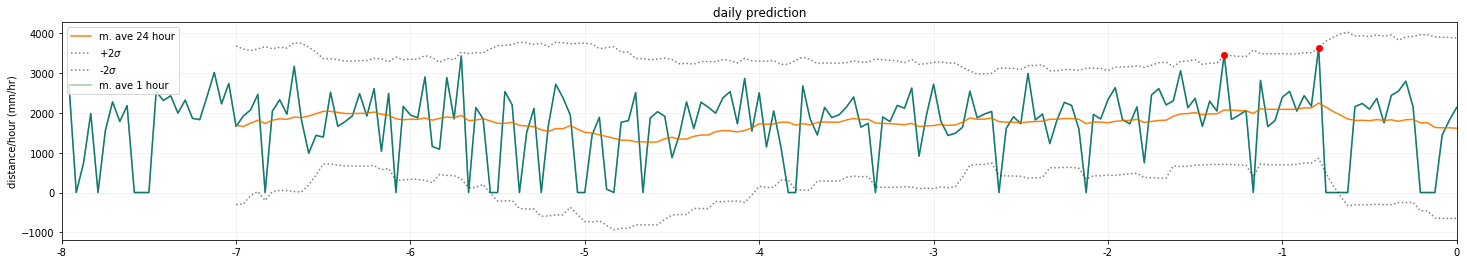

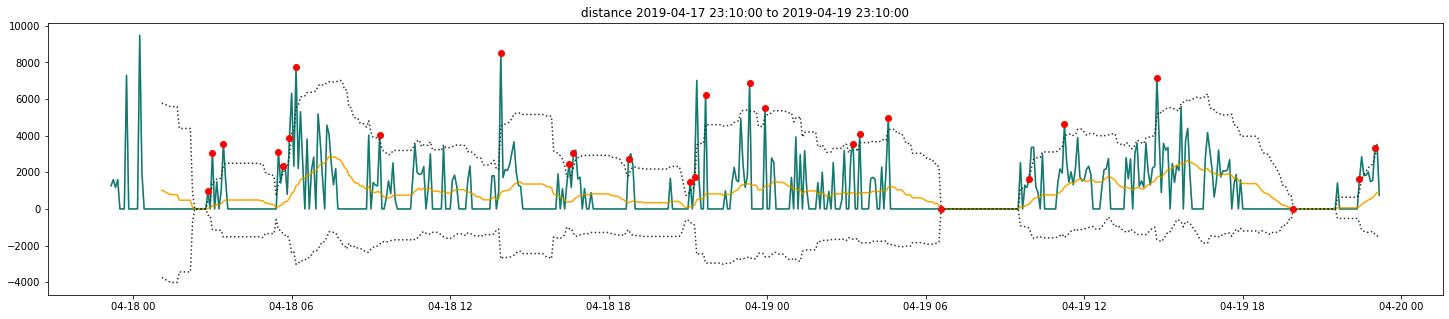

In [348]:
import glob 
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from pandas.tseries.offsets import Hour, Minute
import matplotlib.dates as dates
from numpy import nan as NA
from scipy import stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


filenames = sorted(glob.glob('./Documents/nakayama_calc_all/4330.csv'))
for file in filenames:
    
    df1=pd.read_csv(file,sep=',',converters={'datetime': pd.to_datetime})

    
    s = file.rfind("/")
    e = file.rfind("csv")
    cowID = file[s+1:e-1]
    delta = df1['delta'].iloc[0]
    birth = df1['type'].iloc[0]
    
    
    
    print("ID " + cowID)
    print("  ")
    print("type of birth =", birth)
    print("expected calving days =", '%+d' % delta, "day")
    
    
    # Extract necessary columns and truncate to the second. Then devide into move and stop

    df2=df1.loc[:,['datetime','movement','distance','timedelta']]
    date=df2.loc[:,'datetime']
    dhm=[]
    for d in date:
        hm=datetime(d.year, d.month, d.day, d.hour)
        dhm.append(hm)
    df2['dhm']=dhm
    df_move=df2.query('movement=="move"')
    df_stop=df2.query('movement=="stop"')
    df_move.head()

    # After grouping every minute, the number of rows in the group was counted to determine the frequency. I used frequency as the number of moves.
    # calculated "distance/movingtime" instead of stride.

    #for move
    groupm=df_move.groupby('dhm')
    move=groupm.std()
    temp=groupm.count()
    move=move.reset_index(drop=False)
    temp=temp.reset_index(drop=False)
    move=pd.merge(move, temp, on='dhm', how='outer')
    move=move.iloc[:,:4]
    move.columns=['datetime','distance','movingtime','frequency']
    move['speed']=round(move['distance']/move['movingtime'],2)
    move['movingMin']=round(move['movingtime']/60,2)
    #move.head()


    # Make a timeindex every minute from the beginning to the end.(newdate)
    # df2 contains stop rows.

    start=move.iloc[0,0]
    start=str(start)
    end=df2.iloc[-1,0]
    end=str(end)
    newdate=pd.date_range(start,end, freq='H')

    temp=pd.DataFrame({'datetime':newdate})
    #temp.head()


    # The timeindex(temp) and move table were merged to create a table with a row every minute.

    df3=pd.merge(temp, move, on=['datetime'], how='outer')
    df3.head()

    df3=df3.fillna(0)
    df3.head()


    # Since one line is 1hour, 60-movingMin indicates stoppingMin.

    df3['stoppingMin']=60-df3['movingMin']
    df3.head()
    df3.tail()

    a = 1 
    b = 24
    c = 48
    df4=df3.set_index('datetime', drop=True)
    df5=df4.rolling(b).mean()
    df6=df4.rolling(c).mean()
    
    df4=df4.reset_index(drop=False)
    caltime=df4.iloc[-1,0]
    before=[]
    for d in df4.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df4['beforeCalv']=before


    df5=df5.reset_index(drop=False)
    caltime=df5.iloc[-1,0]
    before=[]
    for d in df5.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df5['beforeCalv']=before
    

    df6=df6.reset_index(drop=False)
    caltime=df6.iloc[-1,0]
    before=[]
    for d in df6.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df6['beforeCalv']=before

    
    merged = df5.merge(df6, on='datetime')
    merged['comparison'] = merged['distance_x']/merged['distance_y']
    
    beginDay= -(df5.iloc[-1,0]-df5.iloc[0,0]).days -1
    during= beginDay*24*60*60
    mpl.rcParams['figure.figsize']=[25,8]
    #sns.set_context('poster')
    
    lowess = sm.nonparametric.lowess(merged['comparison'], merged['beforeCalv_x'], frac=0.1) #LOWESS 
    
    datelist = []
    secondlist = []
    
    def mean(datelist): 
        return sum(datelist) / len(datelist) 
    
    def calc_bb(name, df, window=1):
    # Bollinger Band using 2sigma
        plt.figure(figsize=(25,4))
        plt.title("daily prediction")
        plt.plot(df['beforeCalv'], df[name])
        
        
        n_window = 1
        m_ave = df[name].rolling(window= n_window).mean() 
        m = df[name].rolling(window=window).mean()
        sigma = df[name].rolling(window=window).std()
        
        n_sigma = 2

        df["m"] = m
        df["m+2s"] = m+n_sigma*sigma
        df["m-2s"] = m-n_sigma*sigma

        #df["up"] = df[name] - df["m+2s"]
        #df["down"] = df["m-2s"] - df[name]

        df["up"] = m_ave - df["m+2s"]
        df["down"] = df["m-2s"] - m_ave

        plt.plot(df['beforeCalv'],m, label="m. ave "+str(window)+" hour")
        plt.plot(df['beforeCalv'],m+n_sigma*sigma,label="+"+ str(n_sigma) +"$\sigma$",color="k",alpha=0.5,linestyle="dotted")
        plt.plot(df['beforeCalv'],m-n_sigma*sigma,label="-"+ str(n_sigma) +"$\sigma$",color="k", alpha=0.5,linestyle="dotted")
        plt.plot(df['beforeCalv'],m_ave,label="m. ave "+str(n_window)+" hour",color="green",alpha=0.4)
        #plt.plot(df.index, df[name].rolling(window=3*window).mean(),label="{}min".format(window*30))
        
        for i in range(1,len(df)):
            if df.iloc[i-1]["up"] < 0 and df.iloc[i]["up"] >= 0:
                changepoint = df.iloc[i]["beforeCalv"]
                datelist.append(changepoint)
                secondlist.append(changepoint*-1)
                plt.plot(df['beforeCalv'][i],df.iloc[i][name],"o",color="red",markersize=6)
                print("  ")
                print("alarm", len(datelist))
                print("change point:{}".format((df.iloc[i]["beforeCalv"]/24/60/60))+' days before calving')
                

        average = mean(datelist)/24/60/60
        print("  ")
        print("average alarm to calving day difference =", round(average, 2), "days")
        #print("window size:", n_window, "hour", ",", window, "hour")
        

            #if df.iloc[i-1]["down"] < 0 and df.iloc[i]["down"] >= 0:
                #print("change point decrease time:{}".format(np.round(df.iloc[i]["beforeCalv"]/86400), decimals=5)+' days before calving')
                #plt.plot(df['beforeCalv'][i],df.iloc[i][name],"o",color="blue",markersize=6)

        plt.xlim([during,1])
        plt.xticks(np.arange(during,1,86400),(np.arange(beginDay,1)))
        plt.grid(True, alpha=0.2)
        plt.legend(loc='best')
        #plt.xlabel('Time before calving (days)')
        plt.ylabel('distance/hour (mm/hr)')
        plt.show()

    df = df4
    calc_bb("distance", df, window=24)
    '''
    f, (ax1, ax2) = plt.subplots(2,1, sharex=False)
    
    ax1.plot(df6['beforeCalv'], df4['distance'],label = str(a) + '-h std deviation' , color='grey')
    ax2.plot(df5['beforeCalv'], df5['distance'],label = str(b) + '-h mov avg' , color='green')
    ax2.plot(df6['beforeCalv'], df6['distance'], color='r', label=str(c) + '-h mov avg')
    #ax3.plot(merged['beforeCalv_x'], merged['comparison'], label='comparison')
    #ax3.plot(lowess[:, 0], lowess[:, 1], label='smoothing')
    
    #plt.legend(loc='best')
    #ax1.set_title('distance/hour (mm/hr)')
    
    ax1.grid(True, alpha = 0.3)
    ax2.grid(True, alpha = 0.3)
    #ax3.grid(True, alpha = 0.3)
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    #ax3.legend(loc='best')

    ax1.set_xlim([during,1])
    ax1.set_xticks(np.arange(during,1,86400))
    ax1.set_xticklabels(np.arange(beginDay,1)) 
    #ax1.set_xlabel('Time before calving(days)')
    ax1.set_ylabel('distance/hour (mm/hr)')
    
    ax2.set_xlim([during,1])
    ax2.set_xticks(np.arange(during,1,86400))
    ax2.set_xticklabels(np.arange(beginDay,1)) 
    ax2.set_xlabel('Time before calving(days)')
    ax2.set_ylabel('distance/hour (mm/hr)')
    
    #ax3.set_xlim([during,1])
    #ax3.set_xticks(np.arange(during,1,86400))
    #ax3.set_xticklabels(np.arange(beginDay,1)) 
    #plt.savefig(file[:-4]+ '_plot.png')
    '''
    
    result = df4[pd.DataFrame(df4.beforeCalv.tolist()).isin(datelist).any(1)]
    result['datetimemin'] = result['datetime'] - timedelta(hours=2)  
    result['datetimemax'] = result['datetime'] + timedelta(hours=1) 
    result = result.loc[:,['datetimemin','datetimemax']]
    
    
    df10=df1.loc[:,['datetime','movement','distance','timedelta']]
    date=df10.loc[:,'datetime']
    dhm=[]
    for d in date:
        hm=datetime(d.year, d.month, d.day, d.hour, d.minute)
        dhm.append(hm)
    df10['dhm']=dhm
    df_move=df10.query('movement=="move"')
    df_stop=df10.query('movement=="stop"')
    df_move.head()
    
    groupm=df_move.groupby('dhm')
    move=groupm.mean()
    temp=groupm.count()
    move=move.reset_index(drop=False)
    temp=temp.reset_index(drop=False)
    move=pd.merge(move, temp, on='dhm', how='outer')
    move=move.iloc[:,:4]
    move.columns=['datetime','distance','movingtime','frequency']
    #move['speed']=round(move['distance']/move['movingtime'],2)
    move['movingMin']=round(move['movingtime']/60,2)
    #move.head()
    start=move.iloc[0,0]
    start=str(start)
    end=df10.iloc[-1,0]
    end=str(end)
    newdate=pd.date_range(start,end, freq='T')

    temp=pd.DataFrame({'datetime':newdate})
    
    df11=pd.merge(temp, move, on=['datetime'], how='outer')
    df11.head()

    df11=df11.fillna(0)
    df11.head()

    df11['stoppingMin']=1-df3['movingMin'] #1minutes - moving time
    df12=df11.set_index('datetime', drop=True)
    
      
    df12=df12.reset_index(drop=False)
    caltime=df12.iloc[-1,0]
    before=[]
    for d in df12.iloc[:,0]:
        s=(caltime-d).days*24*60*60+(caltime-d).seconds
        before.append(-s)
    df12['beforeCalv']=before
    df12=df12.set_index('datetime', drop=True)
    
# Define start and end time to see in plot

x = str('2019-04-17 23:10:00')
y = str('2019-04-19 23:10:00')

df12 = df12.loc[x:y]

df20 = df12.distance.resample('5min').ffill() # Resample data to 5 minute

df20.columns = ['datetime', 'distance']

ss = df20.to_frame()

def str2datetime(tstr):
    if tstr.__class__.__name__ == "datetime":
        return tstr
    ts = tstr.split(".")[0]
    return dt.strptime(ts, "%Y-%m-%d %H:%M:%S")

def calc_bb(name, df, window=60):
    # Bollinger Band using 2sigma
    plt.figure(figsize=(25,5))
    plt.title(name + " " + x + " to" + " " +y)
    plt.plot(df.index, df[name])
    
    m_ave = df[name].rolling(window=1).mean() # since data is per 5 minute, then window 1 = 5 minute
    m = df[name].rolling(window=window).mean()
    sigma = df[name].rolling(window=window).std()
    
    df["m"] = m
    df["m+2s"] = m+2*sigma
    df["m-2s"] = m-2*sigma
    
    #df["up"] = df[name] - df["m+2s"]
    #df["down"] = df["m-2s"] - df[name]
    
    df["up"] = m_ave - df["m+2s"]
    df["down"] = df["m-2s"] - m_ave
    
    plt.plot(df.index,m,label="{}minute average".format(window*1), color='orange')
    plt.plot(df.index,m+2*sigma,label="$+2\sigma$",color="k",alpha=0.8,linestyle="dotted")
    plt.plot(df.index,m-2*sigma,label="$-2\sigma$",color="k",alpha=0.8,linestyle="dotted")
    plt.plot(df.index,m_ave,color="green",alpha=0.4)
#   plt.plot(df.index, df[name].rolling(window=3*window).mean(),label="{}min".format(window*30))

    for i in range(1,len(df)):
        if df.iloc[i-1]["up"] < 0 and df.iloc[i]["up"] >= 0:
            #print("change point increase time:{}".format(df.iloc[i]["datetime"]))
            plt.plot(df.index[i],df.iloc[i][name],"o",color="red",markersize=6)
        #if df.iloc[i-1]["down"] < 0 and df.iloc[i]["down"] >= 0:
            #print("change point decrease time:{}".format(df.iloc[i]["datetime"]))
            #plt.plot(df.index[i],df.iloc[i][name],"o",color="blue",markersize=6)
    

plt.show()

calc_bb("distance", ss, window=24) # since data is per 5 minute, then window 24 = 120 minute